In [1]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('TVdata.txt')

In [4]:
df.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [6]:
df.shape

(4226, 16)

# 1. Data Exploration

In [10]:
### check if a video_id appeared more than once
print ('There is no duplicated entry') if df.video_id.nunique() == len(df) else 'There is duplicated entry'

There is no duplicated entry


In [17]:
### overview of numerical features
print (df.drop(['video_id', 'release_year'],axis=1).describe(percentiles = [.1, .25, .5, .75, .95]))
print(((df == 0).sum()) / len(df))
print (df.dtypes)

       cvt_per_day  weighted_categorical_position  \
count     4226.000                       4226.000   
mean      4218.630                          7.783   
std      13036.080                          6.134   
min          2.188                          1.000   
10%        141.985                          3.000   
25%        351.169                          4.000   
50%       1193.500                          6.000   
75%       3356.789                          9.000   
95%      14692.834                         22.000   
max     307127.606                         41.000   

       weighted_horizontal_poition  imdb_votes        budget     boxoffice  \
count                     4226.000    4226.000      4226.000      4226.000   
mean                        28.104    6462.924   2150743.439   2536338.472   
std                         11.864   31596.007   7176604.483   8243516.266   
min                          1.000       0.000         0.000         0.000   
10%                       

###### Among the 10 numerical features (not include video_id and release_year), 4 features have over 25% of missing data: budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.



/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


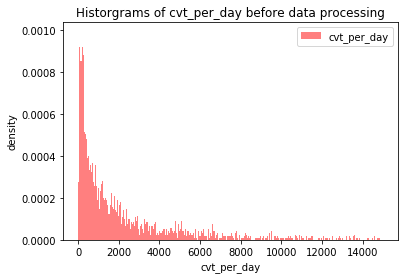

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


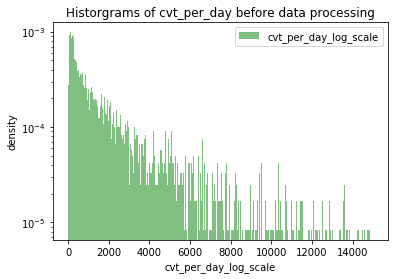

In [22]:
# cvt_per_day data explore
plt.hist(df['cvt_per_day'].values, bins = range(0,15000, 30), alpha = 0.5, color='r', label = 'cvt_per_day', normed = True)
plt.legend(loc ='upper right')
plt.title('Historgrams of cvt_per_day before data processing')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.show()

# log scale of y due to large variation
plt.hist(df['cvt_per_day'].values, log = True, bins = range(0,15000, 30), alpha = 0.5, color='g', label = 'cvt_per_day_log_scale', normed = True)
plt.legend(loc ='upper right')
plt.title('Historgrams of cvt_per_day before data processing')
plt.xlabel('cvt_per_day_log_scale')
plt.ylabel('density')
plt.show()

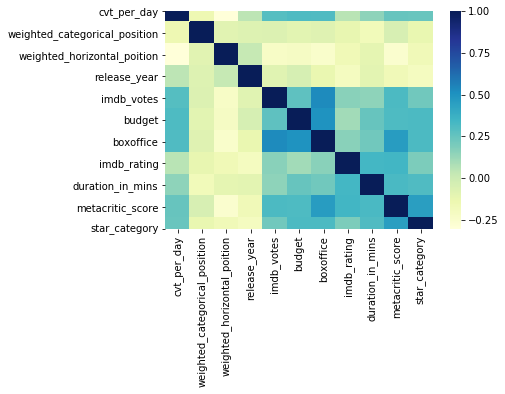

In [23]:
# correlation among numerical features
corr = df[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

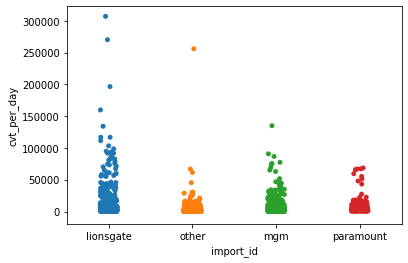

       index  import_id
0      other       2963
1  lionsgate        677
2        mgm        445
3  paramount        141


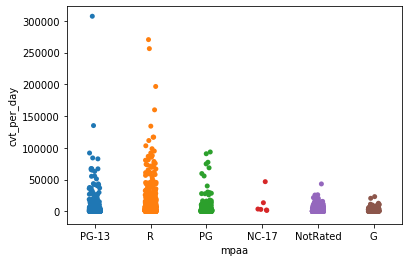

      index  mpaa
0  NotRated  2158
1         R  1158
2     PG-13   426
3        PG   353
4         G   125
5     NC-17     6


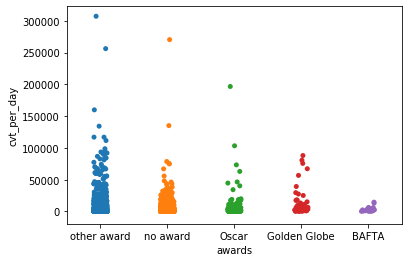

          index  awards
0      no award    2569
1   other award    1453
2         Oscar     141
3  Golden Globe      44
4         BAFTA      19


In [29]:
### categorical features exploration
sns.stripplot(x='import_id', y='cvt_per_day', data=df, jitter=True)
plt.show()
print (df['import_id'].value_counts().reset_index())

sns.stripplot(x='mpaa', y='cvt_per_day', data=df, jitter=True)
plt.show()
print (df['mpaa'].value_counts().reset_index())

sns.stripplot(x='awards', y='cvt_per_day', data=df, jitter=True)
plt.show()
print (df['awards'].value_counts().reset_index())

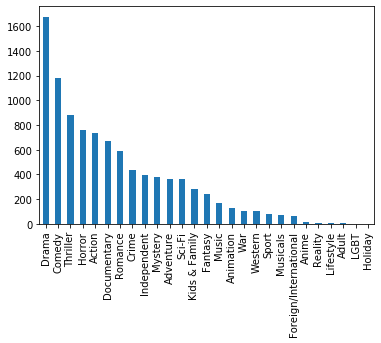

In [32]:
### a movie could belong to more than 1 genre, so we need to split the column to get distribution of each genre
### 6 genres have low frequency, thus later be grouped together under genres column
df.genres.str.get_dummies(sep=',').sum().sort_values(ascending = False).plot.bar()

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


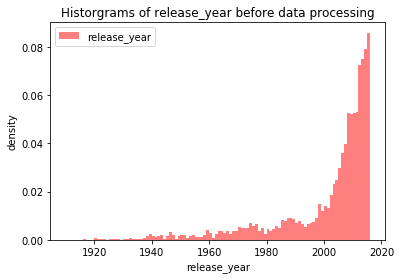

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
20%     1991.000
30%     2001.000
40%     2006.000
50%     2008.000
60%     2010.000
70%     2012.000
80%     2013.000
90%     2014.000
max     2017.000
Name: release_year, dtype: float64


In [35]:
# distribution of release year
# The release year of video varies through a wide range. Considering the popularity of a video usually 
# decays over time, the release_year should be bucketed based on the release_year range.
plt.figure(1)
plt.hist(df['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year', normed = True)
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()

print (df['release_year'].describe(percentiles = [.1, .2, .3, .4,.5, .6, .7, .8, .9]))

# 2. Feature Preprocessing

### Categorical Features
There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There is no missing data in them. They can be converted into dummy/indicators.

The first 3 have relatively small sub-types, they can be easily converted to dummies.

The 'genres' have 27 different sub-types, 6 of them are rarely observed (refer to previous section). It's reasonable to group these 6 into 1. Note: a video may have more than one genre, in the feature preprocessing, all genres are handled individually.

The release_year is bined into 10 buckets based on the year range between 1917 and 2017

In [36]:
# Convert 3 Categorical variables into dummy variables
d_import_id = pd.get_dummies(df['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(df['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(df['awards']).astype(np.int64)

In [45]:
# convert genres into dummy variables
d_genres = df.genres.str.get_dummies(sep=',')
# combine 6 smallest genres into a new genre 'Misc_gen'.  then drop these 6 columns.
d_genres['Misc_gen'] = d_genres['Anime'] * d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [48]:
# bin release year based on percentiles and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014,2017]
year_range = ['1916-1974', '1974-1991', '1991-2001', '2001-2006','2006-2008','2008-2010','2010-2012','2012-2013',
              '2013-2014','2014-2017']
year_bin = pd.cut(df['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [51]:
# now we are ready to join those dummy varible back to our original dataframe
# first, we would need to drop categorical columns from our original dataframe
df1 = df.drop(columns = ['import_id', 'mpaa','awards','genres', 'release_year'])

In [74]:
# perform outter join on all dataframes
# after convering categorical varibles, we now have a dataframe with 58 columns
df2 = pd.concat([df1,d_import_id,d_mpaa,d_awards,d_genres,d_year],axis=1)
print(df2.head)
print(df2.shape)

<bound method NDFrame.head of       video_id  cvt_per_day  weighted_categorical_position  \
0       385504   307127.606                              1   
1       300175   270338.426                              1   
2       361899   256165.867                              1   
3       308314   196622.721                              3   
4       307201   159841.652                              1   
...        ...          ...                            ...   
4221    160848        9.726                              3   
4222    365178        7.913                             29   
4223     11615        2.936                              3   
4224     26365        2.867                              4   
4225     11229        2.188                              7   

      weighted_horizontal_poition  imdb_votes    budget  boxoffice  \
0                               3       69614  15000000   42930462   
1                               3       46705  15000000    3301046   
2              

### Handling of Missing Data
Among the 10 numerical features (not include video_id), 4 features have over 25% of missing values (shown as '0', which is not possible in reality): budget, boxoffice, metacritic_score, star_category. 2 features have less than 10% of missing data: imdb_votes, imdb_rating.

There are 3242 samples have at least one missing data.

In [75]:
df3 = df2.copy()

In [78]:
# replace all 0 values with np.nan
df3[['budget','boxoffice','metacritic_score','star_category','imdb_votes','imdb_rating']] = \
df3[['budget','boxoffice','metacritic_score','star_category','imdb_votes','imdb_rating']].replace(0,np.nan)

In [80]:
print(df3.isna().sum())

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_poition         0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
star_category                    1846
lionsgate                           0
mgm                                 0
other                               0
paramount                           0
G                                   0
NC-17                               0
NotRated                            0
PG                                  0
PG-13                               0
R                                   0
BAFTA                               0
Golden Globe                        0
Oscar                               0
no award                            0
other award                         0
Action      

In [89]:
# fill all NA values with mean value respectively 
df3.imdb_votes.fillna(df3.imdb_votes.mean(),inplace=True)
df3.budget.fillna(df3.budget.mean(),inplace=True)
df3.boxoffice.fillna(df3.boxoffice.mean(),inplace=True)
df3.imdb_rating.fillna(df3.imdb_rating.mean(),inplace=True)
df3.metacritic_score.fillna(df3.metacritic_score.mean(),inplace=True)
df3.star_category.fillna(df3.star_category.mean(),inplace=True)

### Feature Scaling

The impact of different scaling methods on the model performance is small. In the following model training and selections, the standard scaling (sc) data is used.

In [91]:
df3.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,1,3,69614.000,15000000.000,42930462.000,6.500,112.301,51.000,...,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,1,3,46705.000,15000000.000,3301046.000,6.500,94.983,41.000,...,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,1,3,197596.000,26000000.000,37397291.000,7.300,115.764,58.000,...,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,3,4,356339.000,15000000.000,15700000.000,7.600,130.704,94.000,...,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,1,3,46720.000,27220000.000,8551228.000,6.400,105.546,37.000,...,0,0,0,0,0,0,0,1,0,0


In [92]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
df4 = df3.copy()

sc_scale = preprocessing.StandardScaler().fit(df4[scale_lst])
df4[scale_lst] = sc_scale.transform(df4[scale_lst])

df4.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,...,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,...,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,...,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,...,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,...,0,0,0,0,0,0,0,1,0,0


In [93]:
# MinMax scaling
#newTV_mm = newTV_i1.copy()
#mm_scale = preprocessing.MinMaxScaler().fit(newTV_mm[scale_lst])
#newTV_mm[scale_lst] = mm_scale.transform(newTV_mm[scale_lst])

In [94]:
# Robust scaling
#newTV_rs = newTV_i1.copy()
#rs_scale = preprocessing.RobustScaler().fit(newTV_mm[scale_lst])
#newTV_rs[scale_lst] = rs_scale.transform(newTV_rs[scale_lst])

# 3. Model Training

85% of the samples will be used to train all the models, and 15% is reserved for test the models in next section.

In [106]:
# The 20% test data will kept aside, they won't be seen by the models until final test/comparison.
from sklearn.model_selection import train_test_split
model_train, model_test = train_test_split(df4, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = model_test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

### Lasso linear regression model

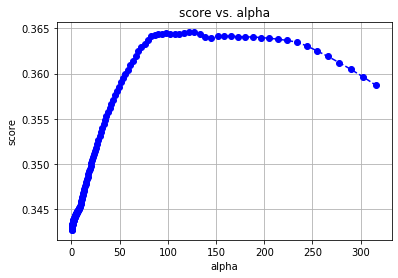

The optimaized alpha and score of Lasso linear is:  122.06107238906554 0.36457853302954235


In [107]:
# Lasso linear regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from math import sqrt

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

alphas = np.logspace (-0.3, 2.5, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = linear_model.Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso linear is: ', opt_a, max_score)

In [108]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = linear_model.Lasso()
lasso_f.set_params(alpha = opt_a)
lasso_f.fit(model_train_x, model_train_y)

# lasso_f is the Lasso model (linear feature), to be tested with final test data.

Lasso(alpha=122.06107238906554, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Lasso with Polynomial Features

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33119365493.446354, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33125575317.33473, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33132740291.53264, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35559652119.729965, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35879533493.85945, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36230317970.722565, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converg

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 450787708.355011, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 318221788.9166107, tolerance: 48022560.445868395
  positive)
/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 203088974.72824097, tolerance: 48022560.445868395
  positive)


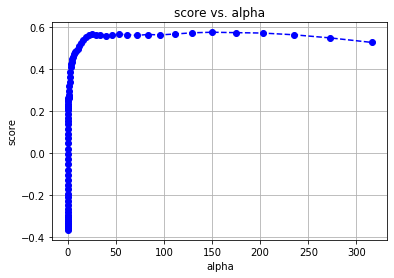

The optimaized alpha and score of Lasso polynomial is:  150.38869469554086 0.5764936326091707


Lasso(alpha=150.38869469554086, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [109]:
# Polynomial features added
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

# lr_train_xp = pd.DataFrame(data=lr_train_xp, index=data[:], columns=data[0,1:]) 

alphas = np.logspace (-2.6, 2.5, num=80)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = linear_model.Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_xp, lr_train_y)
    scores[i] = lasso.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        lasso_save = lasso
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print ('The optimaized alpha and score of Lasso polynomial is: ', opt_a, max_score)

# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = linear_model.Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

In [132]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = linear_model.Lasso()
lasso_fp.set_params(alpha = opt_a)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the Lasso model (polynomial feature), to be tested with test data.

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 278336589.64360046, tolerance: 54965082.96651763
  positive)


Lasso(alpha=14.38449888287663, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

### Ridge Linear Regression

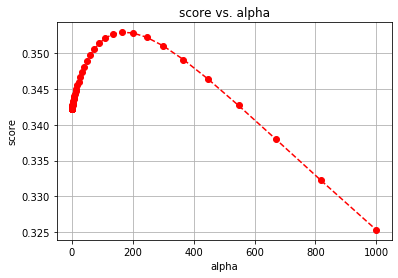

0.352903251542544 163.97026580002054


In [110]:
# Use the same training data set as Lasso (linear features)
lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

alphas = np.logspace (-10, 3, num=150)
# alphas= [0.000000001]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = linear_model.Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
plt.plot(alphas, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print (max_score, opt_a)

In [111]:
# ridge_f is the Ridge model (linear feature), to be tested with test data.
ridge_f = linear_model.Ridge()
ridge_f.set_params(alpha = opt_a)
ridge_f.fit(model_train_x, model_train_y)

Ridge(alpha=163.97026580002054, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Ridge with Polynomial Features

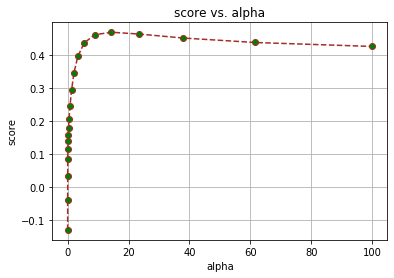

0.46798842420557984 14.38449888287663


In [113]:
# Use the same training data set as Lasso (polynomial features)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)

alphas = np.logspace (-2, 2, num=20)
# alphas= [1]
scores = np.empty_like(alphas)
opt_a = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = linear_model.Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_xp, lr_train_y)
    scores[i] = ridge.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_a = a
        ridge_save = ridge
        
plt.plot(alphas, scores, color='brown', linestyle='dashed', marker='o',markerfacecolor='g', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print (max_score, opt_a)

In [114]:
# add the 15% validate data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

ridge_fp = linear_model.Ridge()
ridge_fp.set_params(alpha = opt_a)
ridge_fp.fit(lr_train_xp1, model_train_y)

# ridge_fp is the Ridge model (polynomial feature), to be tested with test data.

Ridge(alpha=14.38449888287663, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

### Random Forest

In [123]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

rf_train, rf_test = train_test_split(model_train, test_size=0.15, random_state = 0)

rf_train_x = rf_train.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_test_x = rf_test.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_train_y = rf_train['cvt_per_day']
rf_test_y = rf_test['cvt_per_day']

param_grid = {
                 'n_estimators': [54, 55, 56, 57, 58, 59, 60, 62],
                 'max_depth': [12, 13, 14, 15, 16, 17]
             }

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt')
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(rf_train_x, rf_train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=2,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [12, 13, 14, 15, 16, 

In [124]:
grid_rf.best_params_ 

{'max_depth': 14, 'n_estimators': 56}

In [125]:
grid_rf.cv_results_

{'mean_fit_time': array([0.13188434, 0.12833872, 0.13126702, 0.13055658, 0.13534603,
        0.14342284, 0.15654068, 0.16533041, 0.13966584, 0.14890633,
        0.1375762 , 0.14113979, 0.15350533, 0.1564436 , 0.15176253,
        0.15222845, 0.14184318, 0.14245234, 0.14463334, 0.14779134,
        0.15905805, 0.16720109, 0.16230297, 0.15967941, 0.14876943,
        0.14950237, 0.15052624, 0.15475063, 0.15708752, 0.15856614,
        0.16144552, 0.16632361, 0.14997959, 0.15293241, 0.15711851,
        0.15946674, 0.16177287, 0.16506643, 0.16758976, 0.17313209,
        0.15785093, 0.15886984, 0.16205373, 0.16465902, 0.17026882,
        0.17511964, 0.17890439, 0.18346009]),
 'std_fit_time': array([0.01481321, 0.00288148, 0.00222853, 0.00057531, 0.00486219,
        0.00589217, 0.01631866, 0.00684523, 0.00647746, 0.01028627,
        0.00119593, 0.00177096, 0.00964009, 0.01082738, 0.00728368,
        0.00205797, 0.00478898, 0.00070207, 0.0008716 , 0.00161715,
        0.00426458, 0.01052476, 0.001

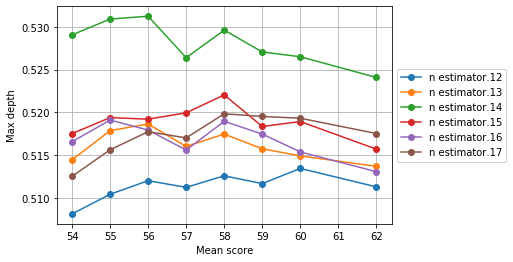

In [126]:
scores = grid_rf.cv_results_['mean_test_score']

n_est = [54, 55, 56, 57, 58, 59, 60, 62]
m_depth=[12, 13, 14, 15, 16, 17]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
fig = plt.figure()
ax = plt.subplot(111)
for ind, i in enumerate(m_depth):
    plt.plot(n_est, scores[ind], '-o', label='n estimator.' + str(i),)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Mean score')
plt.ylabel('Max depth')
plt.grid(True)
plt.show()

In [127]:
# add both training and validation data together as the new training data
rf = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 14, n_estimators=56)
rf.fit(model_train_x, model_train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=56,
                      n_jobs=None, oob_score=False, random_state=2, verbose=0,
                      warm_start=False)

# Model Evaluation

In [130]:
# Lasso_f test (with linear features)

lasso_f_score = lasso_f.score(model_test_x, model_test_y)
pred_y = lasso_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_lasso_f = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('lasso_f score: ', lasso_f_score)
print ('Mean square error of lasso_f: ', MSE_lasso_f)
print ('Root mean squared error of lasso_f:', RMSE_lasso_f)

lasso_f score:  0.09954927178753703
Mean square error of lasso_f:  238953191.99910036
Root mean squared error of lasso_f: 15458.110880670392


In [133]:
# Lasso_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)
pred_y = lasso_fp.predict(model_test_xp)

lasso_fp_score = lasso_fp.score(model_test_xp, model_test_y)
MSE_lasso_fp = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_fp = sqrt(mean_squared_error(model_test_y, pred_y))

print ('lasso_fp score: ', lasso_fp_score)
print ('Mean square error of lasso_fp: ', MSE_lasso_fp)
print ('Root mean squared error of lasso_fp:', RMSE_lasso_fp)

lasso_fp score:  0.3951041437576005
Mean square error of lasso_fp:  160521604.5114302
Root mean squared error of lasso_fp: 12669.71209268112


In [134]:
# ridge_f test (with linear features)

ridge_f_score = ridge_f.score(model_test_x, model_test_y)
pred_y = ridge_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_ridge_f = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('ridge_f score: ', ridge_f_score)
print ('Mean square error of ridge_f: ', MSE_ridge_f)
print ('Root mean squared error of ridge_f:', RMSE_ridge_f)

ridge_f score:  0.11372732348534963
Mean square error of ridge_f:  235190753.2521785
Root mean squared error of ridge_f: 15335.930139778888


In [135]:
# ridge_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)

ridge_fp_score = ridge_fp.score(model_test_xp, model_test_y)
MSE_ridge_fp = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_fp = sqrt(mean_squared_error(model_test_y, pred_y))

pred_y = ridge_fp.predict(model_test_xp)
print ('ridge_fp score: ', ridge_f_score)
print ('Mean square error of ridge_fp: ', MSE_ridge_fp)
print ('Root mean squared error of ridge_fp:', RMSE_ridge_fp)

ridge_fp score:  0.11372732348534963
Mean square error of ridge_fp:  235190753.2521785
Root mean squared error of ridge_fp: 15335.930139778888


In [136]:
rf_score = rf.score(model_test_x, model_test_y)

pred_y = rf.predict(model_test_x)
MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)

rf score:  0.5004288716064247
Mean square error of rf:  132571513.37665495
Root mean squared error of rf: 11513.970356773329


### Comparison Between 5 Models
Compared the max score, mean squared error(MSE), and root mean squared error(RSME) of 5 models. Random forest consistantly showing the best result.

No handles with labels found to put in legend.


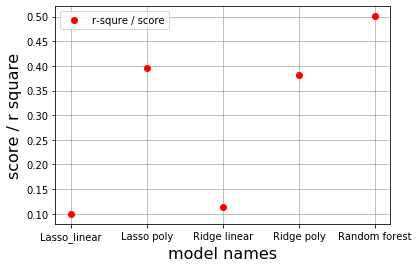

No handles with labels found to put in legend.


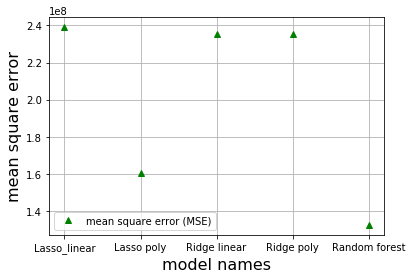

No handles with labels found to put in legend.


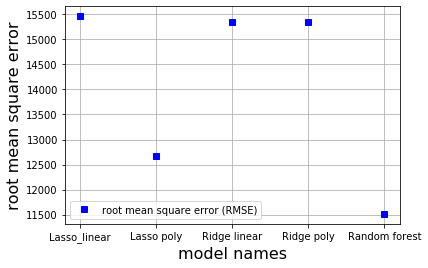

In [140]:
lst_score = [lasso_f_score, lasso_fp_score, ridge_f_score, ridge_fp_score, rf_score]
MSE_lst =  [MSE_lasso_f, MSE_lasso_fp, MSE_ridge_f, MSE_ridge_fp, MSE_rf]
RMSE_lst =  [RMSE_lasso_f, RMSE_lasso_fp, RMSE_ridge_f, RMSE_ridge_fp, RMSE_rf]
model_lst = ['Lasso_linear','Lasso poly', 'Ridge linear', 'Ridge poly', 'Random forest']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(loc = 9)
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(loc = 9)
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(loc = 9)
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

### Feature Importance

Feature importance ranking:
1. feature 2 weighted_categorical_position (0.131688)
2. feature 1 weighted_horizontal_poition (0.129211)
3. feature 0 imdb_votes (0.121377)
4. feature 7 budget (0.067912)
5. feature 3 boxoffice (0.056745)
6. feature 4 imdb_rating (0.053285)
7. feature 6 duration_in_mins (0.046823)
8. feature 8 metacritic_score (0.044479)
9. feature 5 star_category (0.037498)
10. feature 9 lionsgate (0.033263)
11. feature 53 mgm (0.027177)
12. feature 11 other (0.027164)
13. feature 10 paramount (0.017493)
14. feature 18 G (0.017193)
15. feature 28 NC-17 (0.016409)
16. feature 52 NotRated (0.014533)
17. feature 38 PG (0.010977)
18. feature 22 PG-13 (0.009085)
19. feature 49 R (0.008411)
20. feature 42 BAFTA (0.008158)
21. feature 23 Golden Globe (0.007365)
22. feature 29 Oscar (0.006669)
23. feature 30 no award (0.006659)
24. feature 54 other award (0.006514)
25. feature 15 Action (0.006195)
26. feature 17 Adventure (0.006067)
27. feature 27 Animation (0.005764)
28. feature 

/Users/yukunshen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  after removing the cwd from sys.path.


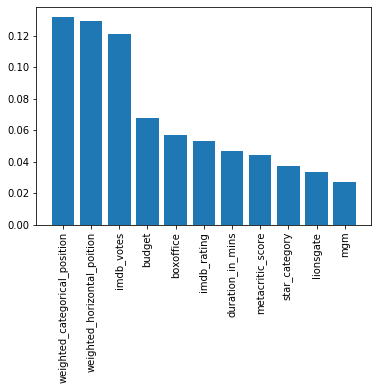

In [141]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = model_test_x.columns.get_values()

# Print the feature ranking
print("Feature importance ranking:")

for f in range(model_test_x.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],  feature_name[f], importances[indices[f]]))
    
plt.figure(1)
plt.bar(feature_name[:11], importances[indices[:11]])
plt.xticks(rotation=90)
plt.show()